In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
from tqdm import tqdm
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 8)

## <font color=orange>  Helper Functions </font>

In [2]:
def calculateBendingAngleAfterSpringback(df,
                                         threshold   = 1.0,
                                         section_dim = 200,
                                         median      = True):

      """Iterates backwards through dataframe in section_dim rows sections and 
      calculates the difference between the first and the last bending angle of 
      the section. If the difference is greater than threshold, the section is 
      considered as out of final beding angle range and the bending angle after 
      springback is calculated as the median of the after springback range.
      param: 
            df          : DataFrame
            threshold   : increasing rate of bedning angle in degrees/section_dim
            section_dim : section dimension to be considered while iterating.
            median      : True to use a median function on the section, that 
                        is considered as part of springback range.
      return: bending angle after springback
      """
      # drop the rows where at least one element is missing
      df.dropna(inplace=True)
      row = len(df) - 1
      while row > 0:
            if abs(df['Bending_Angle'].iloc[row] - df['Bending_Angle'].iloc[row - section_dim]) > threshold:
                  break
            row -= section_dim
      df_springback = df.iloc[row:]
      if median:
            return df_springback['Bending_Angle'].median()
      else:
            return df_springback['Bending_Angle'].mean()

## <font color=orange>  1. Data understanding </font>

In [3]:
# Constants
THRESHOLD_SPRINGBACK = 0.5 # in degrees/section_dim  

In [4]:
# read one data frame
df = pd.read_csv('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/1_10_30_1.csv', sep=';', decimal=',')
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'] - df['Time'][0]
df = df.set_index('Time')
df

,Force1,Force2,Force3,Vibration,Bending_Angle,z_coordinate,delta_alpha,z_dot_soll
Time,,,,,,,,
0 days 00:00:00,-0.348013,-0.210421,0.090366,-0.002861,0.007888,-1000.097168,24.980606,-1.499527
0 days 00:00:00.008000,-0.271492,-0.463391,-0.190020,-0.002861,0.007888,-1000.097168,24.992112,-1.499527
0 days 00:00:00.009000,-0.080189,-0.159827,0.179580,-0.002861,0.007888,-1000.097168,24.992112,-1.499527
0 days 00:00:00.010000,-0.131203,-0.412797,0.128601,-0.001280,0.007888,-1000.097168,24.992112,-1.499527
0 days 00:00:00.011000,-0.156710,-0.185124,-0.011593,-0.001280,0.007888,-1000.097168,24.992112,-1.499527
...,...,...,...,...,...,...,...,...
0 days 00:00:56.640000,-0.386273,-1.019924,-0.024337,-0.001280,26.632736,-1000.384827,3.367264,-0.202036
0 days 00:00:56.642000,-0.411781,-1.108463,0.510946,-0.002861,26.632736,-1000.384827,3.367264,-0.202036
0 days 00:00:56.643000,-0.513809,-1.057869,0.944270,-0.001280,26.632736,-1000.384827,3.367264,-0.202036


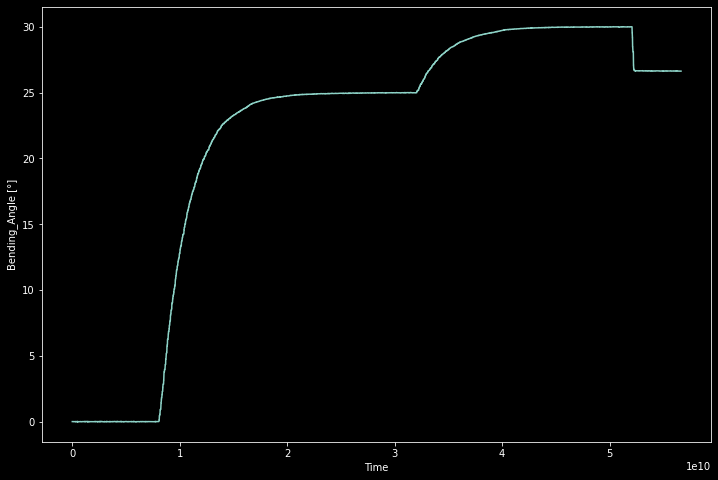

In [5]:
# plot bending angle over time
plt.plot(df.index, df['Bending_Angle'], label='Bending_Angle')
plt.xlabel('Time')
plt.ylabel('Bending_Angle [°]')
plt.show()

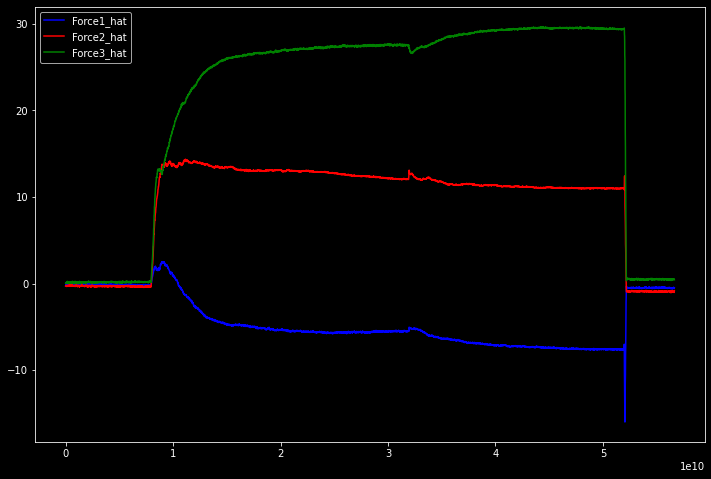

In [6]:
# low pass filter on force columns
window_length = 30
poly_order = 3
Force1 = df['Force1'].tolist()
Force2 = df['Force2'].tolist()
Force3 = df['Force3'].tolist()
Force1_hat = scipy.signal.savgol_filter(Force1, window_length=window_length, polyorder=poly_order)
Force2_hat = scipy.signal.savgol_filter(Force2, window_length=window_length, polyorder=poly_order)
Force3_hat = scipy.signal.savgol_filter(Force3, window_length=window_length, polyorder=poly_order)

# plot force curves over time
plt.plot(df.index, Force1_hat, 'b', label='Force1_hat')
plt.plot(df.index, Force2_hat, 'r', label='Force2_hat')
plt.plot(df.index, Force3_hat, 'g', label='Force3_hat')
plt.legend()
plt.show()

  8%|▊         | 29/363 [00:50<09:42,  1.75s/it]


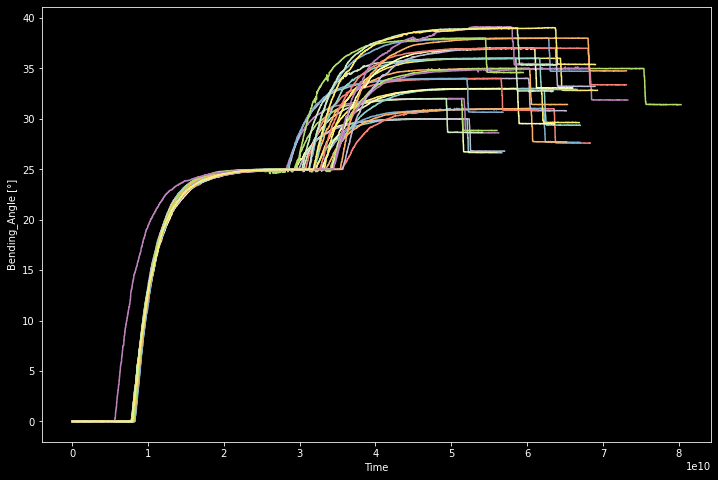

In [7]:
# plot multiple bending angles over time
files = os.listdir('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/')
files = [f for f in files if f.endswith('.csv')]
i = 0
# iterate over all csv files in folder
for file in tqdm(files):
    i += 1
    df = pd.read_csv('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/' + str(file), sep=';', decimal=',')
    df['Time'] = pd.to_datetime(df['Time'])
    df['Time'] = df['Time'] - df['Time'][0]
    plt.plot(df['Time'], df['Bending_Angle'], label='Bending_Angle_' + str(file))
    if i == 30:
        break
plt.xlabel('Time')
plt.ylabel('Bending_Angle [°]')
plt.show()

100%|██████████| 363/363 [00:25<00:00, 14.33it/s]


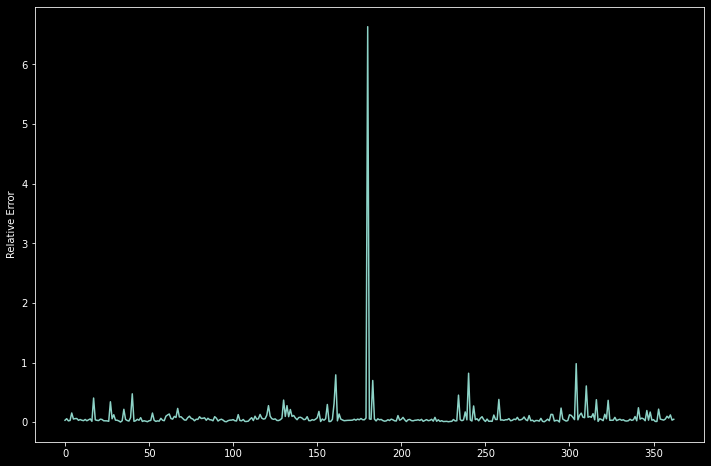

In [8]:
# comapre max reference bending angle with max measured bending angle 
files = os.listdir('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/')
files = [f for f in files if f.endswith('.csv')]
ref_values = []
meas_values = []
for file in tqdm(files):
    ref_bending_angle = int(file.split('_')[2])
    df = pd.read_csv('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/' + str(file), sep=';', decimal=',')
    meas_bending_angle = df['Bending_Angle'].max()
    ref_values.append(ref_bending_angle)
    meas_values.append(meas_bending_angle)

# plot the relative error between reference and measured bending angle
relative_error = [abs(meas - ref) * 100 / ref for meas,ref in zip(ref_values,meas_values)]
plt.plot(relative_error)
plt.ylabel('Relative Error')
plt.show()


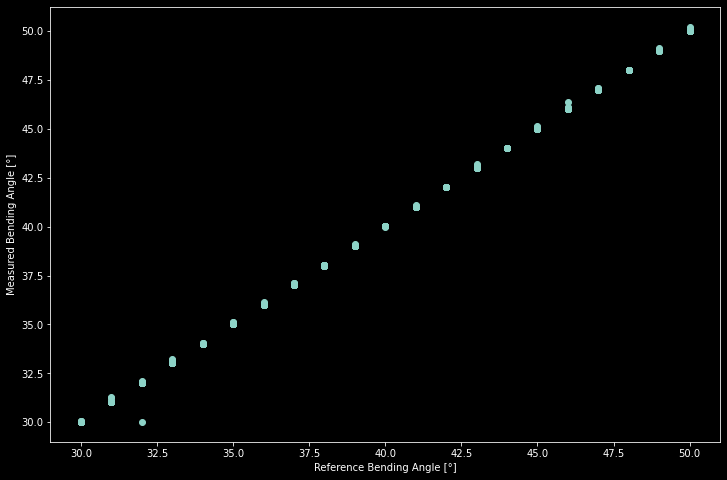

In [9]:
# plot reference against measured bending angle
plt.plot(ref_values, meas_values, 'o')
plt.xlabel('Reference Bending Angle [°]')
plt.ylabel('Measured Bending Angle [°]')
plt.show()

In [10]:
# check wheter bending angle after spring back is calculated correctly
files = os.listdir('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/')
files = [f for f in files if f.endswith('.csv')]
bending_angles_asb = []
bending_angles_max = []
for file in tqdm(files):
    df = pd.read_csv('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/' + str(file), sep=';', decimal=',')
    meas_bending_angle = df['Bending_Angle'].max()
    bending_angle_after_springback = calculateBendingAngleAfterSpringback(df, threshold=THRESHOLD_SPRINGBACK, section_dim=200, median=True)
    bending_angles_max.append(meas_bending_angle)
    bending_angles_asb.append(bending_angle_after_springback)

100%|██████████| 363/363 [00:28<00:00, 12.66it/s]


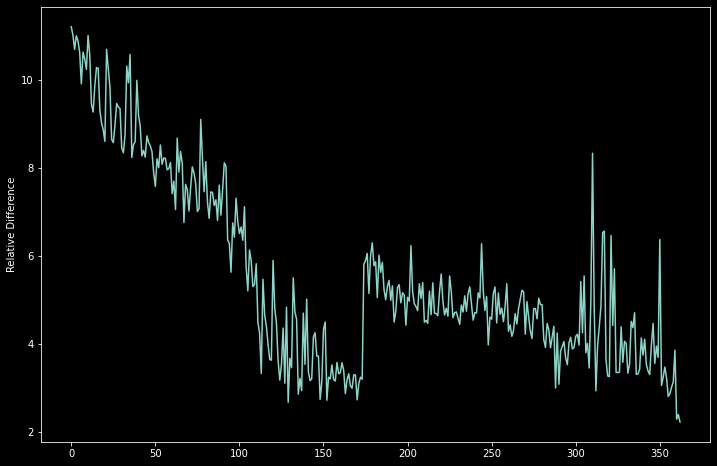

In [12]:
# plot the relative error between max. reference bending angle and measured bending angle after springback
relative_error = [(j - i) * 100 / j for i,j in zip(bending_angles_asb, bending_angles_max)]
plt.plot(relative_error)
plt.ylabel('Relative Difference')
plt.show()

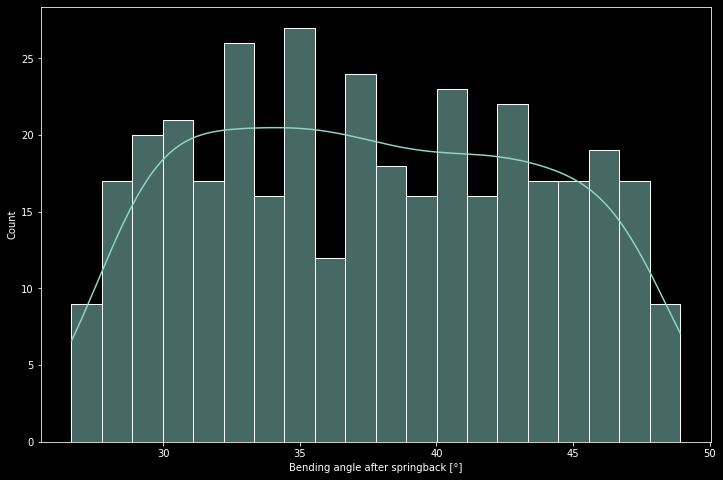

In [13]:
sns.histplot(data=bending_angles_asb, kde=True, bins=20)
plt.xlabel('Bending angle after springback [°]')
plt.show()

In [15]:
for i in range(len(bending_angles_asb)):
    if bending_angles_asb[i] > 48:
        print(i)

171
172
173
298
299
360
361
362


In [16]:
files = os.listdir('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/')
files = [f for f in files if f.endswith('.csv')]
file = files[360]
df = pd.read_csv('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/' + str(file), sep=';', decimal=',')
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'] - df['Time'][0]
df = df.set_index('Time')
df


,Force1,Force2,Force3,Vibration,Bending_Angle,z_coordinate,delta_alpha,z_dot_soll
Time,,,,,,,,
0 days 00:00:00,-0.159754,-0.256349,0.196516,-0.001280,0.012074,-1000.148865,24.998363,-1.499276
0 days 00:00:00.006000,-0.325549,-0.344888,-0.032891,-0.004442,0.012074,-1000.148865,24.987163,-1.499276
0 days 00:00:00.007000,-0.274535,-0.370185,0.183771,-0.002861,0.012074,-1000.148865,24.987926,-1.499276
0 days 00:00:00.008000,-0.057726,-0.319591,0.387688,0.000301,0.012074,-1000.148865,24.987926,-1.499276
0 days 00:00:00.009000,0.286619,0.312833,0.094557,-0.002861,0.012074,-1000.148865,24.987926,-1.499276
...,...,...,...,...,...,...,...,...
0 days 00:01:25.352000,-0.044972,-0.129864,0.387688,-0.001280,48.908101,-1000.446289,1.091899,-0.065514
0 days 00:01:25.354000,0.069810,-0.142512,0.272985,-0.002861,48.908101,-1000.446289,1.091899,-0.065514
0 days 00:01:25.356000,-0.134247,-0.306943,0.247495,-0.002861,48.908101,-1000.446289,1.091899,-0.065514


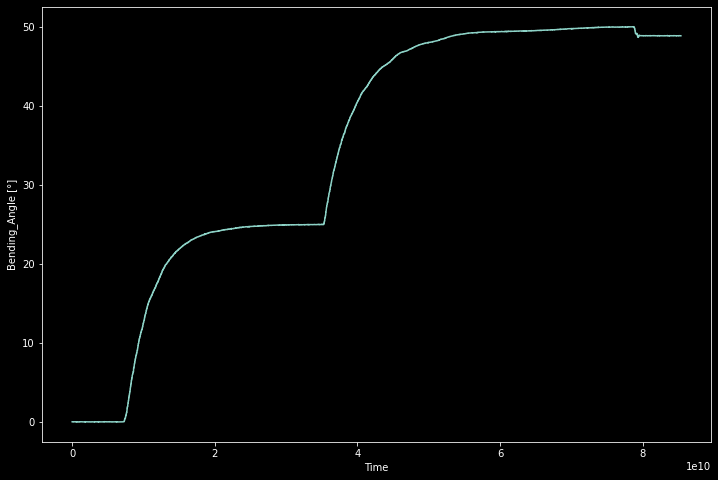

In [17]:
plt.plot(df.index, df['Bending_Angle'], label='Bending_Angle')
plt.xlabel('Time')
plt.ylabel('Bending_Angle [°]')
plt.show()

## <font color=orange>  Fragen </font>
* Soll- oder gemessener Wert des maximal angefahrenen Biegewinkels fürs ML Model?